In [17]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Define the CNN model structure
class RockPaperScissorsCNN(nn.Module):
    def __init__(self):
        super(RockPaperScissorsCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 output classes: rock, paper, scissors, unknown  
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the trained model
model_path = "rps_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RockPaperScissorsCNN().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Define the transformation for test images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [18]:
# Function to predict a single image
def predict_image(image_path):
    """
    Predict the class of an image using the trained model
    """
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    
    # Convert prediction to class name
    classes = ['rock', 'paper', 'scissors', 'unknown']
    predicted_class = classes[predicted.item()]
    
    # Create results dictionary
    results = {
        'class': predicted_class,
        'probabilities': {classes[i]: float(probabilities[i]) * 100 for i in range(len(classes))}
    }
    
    # Display the results
    display_results(image_path, results)
    
    return results

# Function to display results
def display_results(image_path, prediction_results):
    """
    Display the image and prediction results
    """
    # Load and display the image
    image = Image.open(image_path).convert('RGB')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the image
    ax1.imshow(image)
    ax1.set_title('Test Image')
    ax1.axis('off')
    
    # Display the prediction probabilities as a bar chart
    classes = list(prediction_results['probabilities'].keys())
    probabilities = list(prediction_results['probabilities'].values())
    
    colors = ['blue' if cls != prediction_results['class'] else 'green' for cls in classes]
    
    ax2.barh(classes, probabilities, color=colors)
    ax2.set_xlim(0, 100)
    ax2.set_title('Prediction Probabilities (%)')
    ax2.set_xlabel('Probability (%)')
    
    plt.tight_layout()
    plt.show()
    
    # Print the results
    print(f"Predicted class: {prediction_results['class']}")
    print("\nProbabilities:")
    for cls, prob in prediction_results['probabilities'].items():
        print(f"{cls}: {prob:.2f}%")

# Function to test multiple images in a directory
def predict_directory(directory_path):
    """
    Test all JPEG images in a directory
    """
    # Get all jpg/jpeg files in the directory
    image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                  if f.lower().endswith(('.jpg', '.jpeg'))]
    
    if not image_files:
        print("No JPEG images found in the directory.")
        return
    
    print(f"Found {len(image_files)} images.")
    
    # Process each image
    results = {}
    for image_path in image_files:
        print(f"\nProcessing: {os.path.basename(image_path)}")
        results[image_path] = predict_image(image_path)
    
    return results

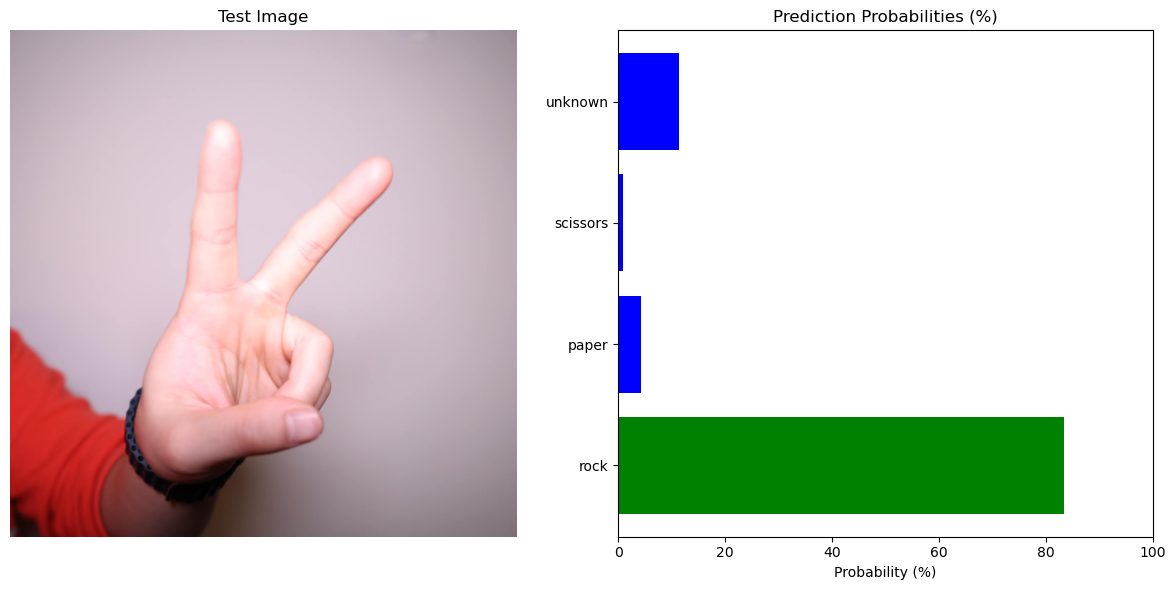

Predicted class: rock

Probabilities:
rock: 83.38%
paper: 4.34%
scissors: 0.85%
unknown: 11.43%


{'class': 'rock',
 'probabilities': {'rock': 83.37751030921936,
  'paper': 4.3440960347652435,
  'scissors': 0.8498197421431541,
  'unknown': 11.428578943014145}}

In [24]:
# Example usage:
predict_image("Dataset/test/7.jpg")
# predict_directory("path/to/your/directory")